In [1]:
import os
import pandas as pd
import numpy as np
import random


from keras.models import load_model, Model
from keras.layers import Dense, Input, LSTM, BatchNormalization, Concatenate, Lambda, Reshape, Masking, Dropout
from keras.initializers import glorot_uniform
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from keras import backend as K

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard

In [2]:
data_dir = '/Users/tianqiyan/Documents/DeepLearning/cs230/project'
data_file = os.path.join(data_dir, 'skill_build_processed.csv')
data_processed = pd.read_csv(data_file)

In [3]:
data_processed

,order_id,user_id,problem_id,correct,skill_1,skill_2,skill_4,skill_5,skill_8,skill_9,...,skill_371,skill_375,skill_378,answer_type_algebra,answer_type_choose_1,answer_type_choose_n,answer_type_fill_in_1,answer_type_open_response,ms_first_response,hint_count
0,20224085,73963,76429,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,106016,0
1,20224095,73963,76430,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,194187,0
2,20224113,73963,76431,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,12734,0
3,20224123,73963,76432,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,333484,0
4,20224142,73963,76433,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,52828,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283100,38310198,96282,135605,1,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,12402,0
283101,38310199,96282,135607,1,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,10680,0
283102,38310200,96282,135601,1,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,5230,0
283103,38310201,96282,135602,1,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,5532,0


In [4]:
# break down the data into data.frame of each user
data_processed_user = [x[1] for x in data_processed.groupby('user_id')]

In [5]:
# the shape is in (# of attempts, 134)
data_processed_user[10].shape

(20, 134)

In [6]:
# hyperparameters
Tx = 16
print('length of the sequence: {}'.format(Tx))
embedded_size = 128    # number of dimensions for the embedding output
print('number of dimensions for the embedding output: {}'.format(embedded_size))
n_a = 256
print('number of dimensions for the hidden state of each LSTM cell: {}'.format(n_a))

length of the sequence: 16
number of dimensions for the embedding output: 128
number of dimensions for the hidden state of each LSTM cell: 256


In [7]:
def split_into_seq(df, Tx, pad = True):
    if len(df.index) < Tx+1:
        # with padding
        if pad:
            df_tmp = df.iloc[:, 3:].to_numpy()
            return (np.pad(df_tmp, ((0, Tx+1-df_tmp.shape[0]), (0, 0))),)
        else:
            return None
    else:
        extra_row = len(df.index) % (Tx+1)
        if extra_row > 0:
            df_tmp = pd.concat([df.iloc[0: len(df.index) - extra_row, :], df.iloc[len(df.index)-(Tx+1): len(df.index), :]])
        else:
            df_tmp = df
        arr_tmp = df_tmp.iloc[:, 3:].to_numpy()
        return(np.array_split(arr_tmp, arr_tmp.shape[0]/(Tx + 1)))

class DataGenerator(object):
    def __init__(self, file_name, num_seq, pad = True):
        """

        :param file_name: full path of dataset
        :param num_seq: number of sequence
        """
        self.filename = file_name
        self.train_seq = []
        self.dev_seq = []
        self.test_seq = []
        self.Tx = num_seq
        self.pad = pad

    def read_data(self):
        # read data and sorted by student_id
        data = pd.read_csv(self.filename).sort_values('user_id')
        # group by user_id
        data_by_user = [x[1] for x in data.groupby('user_id')]
        seqs_by_student = list(map(lambda x: split_into_seq(x, self.Tx, pad = self.pad), data_by_user))
        seqs_by_student = list(filter(lambda x: x is not None, seqs_by_student))
        seqs_by_student = [item for items in seqs_by_student for item in items]
        seqs_by_student = np.stack(seqs_by_student)
        return seqs_by_student

    def split_data(self, random_seed=1):
        """

        :param seqs_by_student:
        :param random_seed:
        :return:
        """
        random.seed(random_seed)
        seqs_by_student = self.read_data()
        random.shuffle(seqs_by_student)
        n = seqs_by_student.shape[0]

        split_1 = int(0.9 * n)
        split_2 = int(0.95 * n)
        self.train_seq = seqs_by_student[:split_1]
        self.dev_seq = seqs_by_student[split_1:split_2]
        self.test_seq = seqs_by_student[split_2:]

In [8]:
data = DataGenerator(data_file, 16, pad = False)
data.split_data(200)

In [9]:
print(f"Train shape:{data.train_seq.shape}")
print(f"Dev shape:{data.dev_seq.shape}")
print(f"Test shape:{data.test_seq.shape}")

Train shape:(15278, 17, 131)
Dev shape:(849, 17, 131)
Test shape:(849, 17, 131)


In [10]:
Y_train = data.train_seq[:, 1:, [0]]
X_train = np.concatenate([data.train_seq[:, 0:Tx, :], data.train_seq[:, 1:, 1:124]], axis = 2)

Y_dev = data.dev_seq[:, 1:, [0]]
X_dev = np.concatenate([data.dev_seq[:, 0:Tx, :], data.dev_seq[:, 1:, 1:124]], axis = 2)

Y_test = data.test_seq[:, 1:, [0]]
X_test = np.concatenate([data.test_seq[:, 0:Tx, :], data.test_seq[:, 1:, 1:124]], axis = 2)

In [11]:
print(Y_train.shape)
print(X_train.shape) 
# 0: correctness for t; [1: 124]: skill tags for t; [124:131]: other meta for t; [131: 254]: skill tags for t+1

print(Y_dev.shape)
print(X_dev.shape)

print(Y_test.shape)
print(X_test.shape)

(15278, 16, 1)
(15278, 16, 254)
(849, 16, 1)
(849, 16, 254)
(849, 16, 1)
(849, 16, 254)


In [12]:
m = X_train.shape[0]
print("Number of training examples : {}".format(m))

Number of training examples : 15278


In [20]:
embedding_cell = Dense(units=embedded_size, activation=None, name='embedding')

In [21]:
def DKT_model(Tx, n_a, pad = True):
    """
    break down X into :
        - correct_1: correctness t
        - s_1:  skill vector t
        - other_categorical: other one-hot meta
        - other_numeric: other numerical meta
        - s_2: skill vector t + 1
        
    
    1. embed s_1, s_2
    2. normalize other_categorical
    3. new X: [c, s1, o1, o2]
    4. a2 = LSTM_layer(new_X, c1, a1)
    5. y' = sigmoid_layer([a2, s2])
    
    loss = binary cross entropy
    
    """
    
    # Define the input layer and specify the shape
    X = Input(shape=(Tx, 254))
    
    # Define the initial hidden state a0 and initial cell state c0
    a0 = Input(shape=(n_a,), name='a0')
    c0 = Input(shape=(n_a,), name='c0')
    
    # pre-process X
    s_1 = embedding_cell(Lambda(lambda z: z[:, :, 1: 124], name='Skill_t1')(X))      # embed the skill vector for t
    s_2 = embedding_cell(Lambda(lambda z: z[:, :, 131: 254], name='Skill_t2')(X))    # embed the skill vector for t + 1
    correct_1 = Reshape((Tx, 1))(Lambda(lambda z: z[:, :, 0], name='correctness_t1')(X))
    other_categorical = Lambda(lambda z: z[:, :, 124:129], name='other_categorical')(X)
    other_numeric = BatchNormalization(name = 'bn0')(Lambda(lambda z: z[:, :, 129:131], name='other_num')(X))
    
    X_new = Concatenate(axis = -1)([correct_1, s_1, other_categorical, other_numeric])
    if pad:
        X_new = Masking(mask_value=0)(X_new)
    X_new = Dropout(rate = 0.5)(X_new)
    if pad:
        s_2 = Masking(mask_value=0)(s_2)
    
    a = LSTM(n_a, return_sequences = True, name = 'LSTM_1')(inputs=X_new, initial_state=[a0, c0])
    a_reg = Concatenate(axis = -1)([a, s_2])
    a_reg = Dropout(rate = 0.5)(a_reg)
    out = Dense(units=1, activation="sigmoid", name='output')(a_reg)

    # Step 3: Create model instance
    model = Model(inputs=[X, a0, c0], outputs=out)
    return model

In [22]:
model = DKT_model(Tx, n_a, pad=False)

In [23]:
opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.01)

model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['AUC', 'accuracy'])

In [24]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 16, 254)]    0                                            
__________________________________________________________________________________________________
correctness_t1 (Lambda)         (None, 16)           0           input_2[0][0]                    
__________________________________________________________________________________________________
Skill_t1 (Lambda)               (None, 16, 123)      0           input_2[0][0]                    
__________________________________________________________________________________________________
other_num (Lambda)              (None, 16, 2)        0           input_2[0][0]                    
____________________________________________________________________________________________

In [ ]:
a0 = np.zeros((m, n_a))
c0 = np.zeros((m, n_a))

In [ ]:
%load_ext tensorboard

In [ ]:
logdir = os.path.join(data_dir, "logs")
callbacks = [
  ModelCheckpoint(filepath='dkt_best_model.h5', monitor='val_loss', 
    save_best_only=True),
  TensorBoard(logdir, histogram_freq=1)
]

In [ ]:
a0_dev = np.zeros((X_dev.shape[0], n_a))
c0_dev = np.zeros((X_dev.shape[0], n_a))

In [ ]:
history = model.fit([X_train, a0, c0], Y_train, epochs=1000, callbacks=callbacks, verbose=2, validation_data=([X_dev, a0_dev, c0_dev], Y_dev))

In [ ]:
loss, auc, accuracy = model.evaluate(x= [X_dev, a0_dev, c0_dev], y = Y_dev)

In [ ]:
type(history)

In [ ]:
%tensorboard --logdir logs # starts tensboard, will automatically update once model is training

In [ ]:
loss, auc, accuracy = model.evaluate(x= [X_test, a0_dev, c0_dev], y = Y_test)

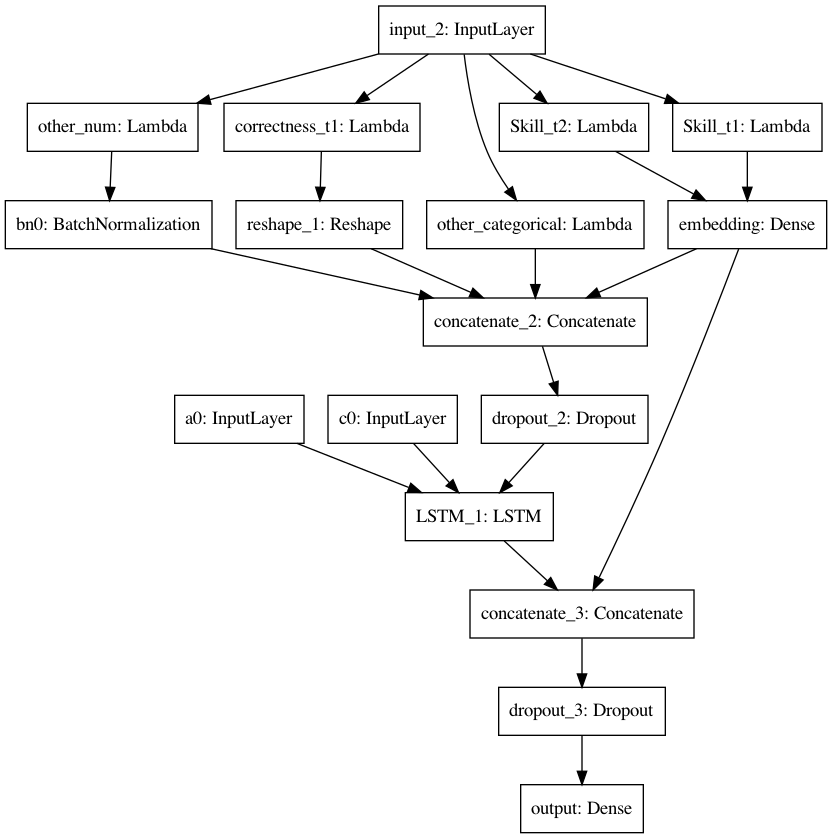

In [25]:
import tensorflow as tf
tf.keras.utils.plot_model(model, to_file='model_plot.png')